# Простой пример использования библиотеки для извлечения навыков из текста

Ссылка на репозиторий с моделями:
https://github.com/explosion/spacy-models/releases

In [1]:
# Скачаем модель с помощью команды
#!python -m spacy download en_core_web_lg
#!python -m spacy download ru_core_news_lg

In [2]:
# Импортируем необходимые библиотеки
import spacy
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB
from skillNer.skill_extractor_class import SkillExtractor

In [3]:
# Загружаем модель и создаём экземпляр класса для извлечения навыков
nlp = spacy.load("ru_core_news_lg")
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [4]:
job_description = """
Обязанности:

— Разработка API для конфигурации и управления телеком-приложениями
— Разработка сервисов/микросервисов для обсеспечения взаимодействия с внутренними системами, операторами связи и их партнерами.
— Проектирование и разработка бизнес-логики CRM-систем
— Интеграция с внешними сервисами

Требования:

— Уверенные знания PHP 7/8. Понимание сильных и слабых сторон языка.
— Опыт разработки на одном из современных фреймворков Symfony/Laravel. Предпотчение кандидатам с опытом работы на Symfony 5.
— Опыт использования различных ORM, опыт работы с Doctrine/Eloquent приветствуется.
— Опыт написания автотестов на PHPUnit. Желателен так же опыт работы с любым из фреймворков Codeception/Behat/PHPSpec.
— Знание принципов разработки REST API или RPC. Желательно уметь работать с OpenAPI / Swagger.
— Опыт работы с PostgreSQL, написание и оптимизация сложных запросов (предстоит работать с таблицами, имеющими более сотни миллионов записей).
— Опыт работы с Clickhouse, написание и оптимизация сложных запросов.
— Знание протокола AMQP, опыт работы с брокерами сообщений типа RabbitMQ, Kafkа.
— Опыт работы с Docker и с любым из инструментов оркестрации контейнеров (docker-compose, k8s, swarm).
— Опыт работы с инструментами CI/CD (Gitlab CI, Travis CI, Jenkins и другими).
— Уверенное владение Composer.
— Уверенное владение навыками работы с консолью (shell/ssh).
— Уверенное владение git.

Будет плюсом

— Примеры кода на Github
— Опыт работы с высокими нагрузками и большими объемами данных.
— Успешный опыт удаленной работы.
— Английский на уровне ведения переписки.

Личные качества:

— Способность работать в команде, взаимодействовать с технически подкованным бизнесом и смежными командами разработки и эксплуатации
— Увлечённость и самомотивация обязательны, желание изучать новое и развиваться
"""

# Извлекаем навыки из текста
annotations = skill_extractor.annotate(job_description)
print(annotations)

{'text': 'обязанности — разработка api для конфигурации и управления телеком приложениями — разработка сервисов микросервисов для обсеспечения взаимодействия с внутренними системами операторами связи и их партнерами — проектирование и разработка бизнес логики crm систем — интеграция с внешними сервисами требования — уверенные знания php 7 8 понимание сильных и слабых сторон языка — опыт разработки на одном из современных фреймворков symfony laravel предпотчение кандидатам с опытом работы на symfony 5 — опыт использования различных orm опыт работы с doctrine eloquent приветствуется — опыт написания автотестов на phpunit желателен так же опыт работы с любым из фреймворков codeception behat phpspec — знание принципов разработки rest api или rpc желательно уметь работать с openapi swagger — опыт работы с postgresql написание и оптимизация сложных запросов предстоит работать с таблицами имеющими более сотни миллионов записей — опыт работы с clickhouse написание и оптимизация сложных запро

## Выводим список извлечённых навыков

Тут важный момент в том, что навыки могут быть извлечены не только из текста, но и из контекста. Например, в тексте может быть упомянуто слово "php", но в контексте может быть упомянуто "php 7" или "php 8". В таком случае, чтобы в список навыков не попадали дубликаты, мы объединяем их в один навык.

In [5]:
technologies = set()

full_matches = annotations['results']['full_matches']
for match in full_matches:
    technology = match['doc_node_value'].lower()
    technologies.add(technology)

ngram_scored = annotations['results']['ngram_scored']
for ngram in ngram_scored:
    technology = ngram['doc_node_value'].lower()
    technologies.add(technology)

from mapping.replacements import REPLACEMENTS
for key, values in REPLACEMENTS.items():
    for value in values:
        if value in technologies:
            technologies.remove(value)
            technologies.add(key)

technologies_list = sorted(list(technologies))
print("Список технологий:", technologies_list)

Список технологий: ['api', 'behat', 'codeception', 'crm', 'docker', 'git', 'github', 'gitlab', 'jenkins', 'laravel', 'openapi', 'php', 'phpspec', 'phpunit', 'postgresql', 'rabbitmq', 'rest api', 'swagger', 'symfony', 'travis-ci']


In [6]:
from simple_gnn.graph.builder import build_from_list
from mapping.relations import RELATIONS

# Из полученного массива составим граф навыков
graph = build_from_list(tech_list=technologies_list, exclude_isolated=False, relations=RELATIONS)
print(graph)

{'nodes': [{'id': 'api', 'weight': 0.0}, {'id': 'behat', 'weight': 0.0}, {'id': 'codeception', 'weight': 0.0}, {'id': 'crm', 'weight': 0.0}, {'id': 'docker', 'weight': 0.0}, {'id': 'git', 'weight': 0.0}, {'id': 'github', 'weight': 0.0}, {'id': 'gitlab', 'weight': 0.0}, {'id': 'jenkins', 'weight': 0.0}, {'id': 'laravel', 'weight': 0.0}, {'id': 'openapi', 'weight': 0.0}, {'id': 'php', 'weight': 0.0}, {'id': 'phpspec', 'weight': 0.0}, {'id': 'phpunit', 'weight': 0.0}, {'id': 'postgresql', 'weight': 0.0}, {'id': 'rabbitmq', 'weight': 0.0}, {'id': 'rest api', 'weight': 0.0}, {'id': 'swagger', 'weight': 0.0}, {'id': 'symfony', 'weight': 0.0}, {'id': 'travis-ci', 'weight': 0.0}], 'links': [{'source': 'php', 'target': 'laravel', 'weight': 1}, {'source': 'php', 'target': 'symfony', 'weight': 1}, {'source': 'php', 'target': 'phpunit', 'weight': 1}, {'source': 'php', 'target': 'phpspec', 'weight': 1}, {'source': 'php', 'target': 'codeception', 'weight': 1}, {'source': 'php', 'target': 'behat', 'w

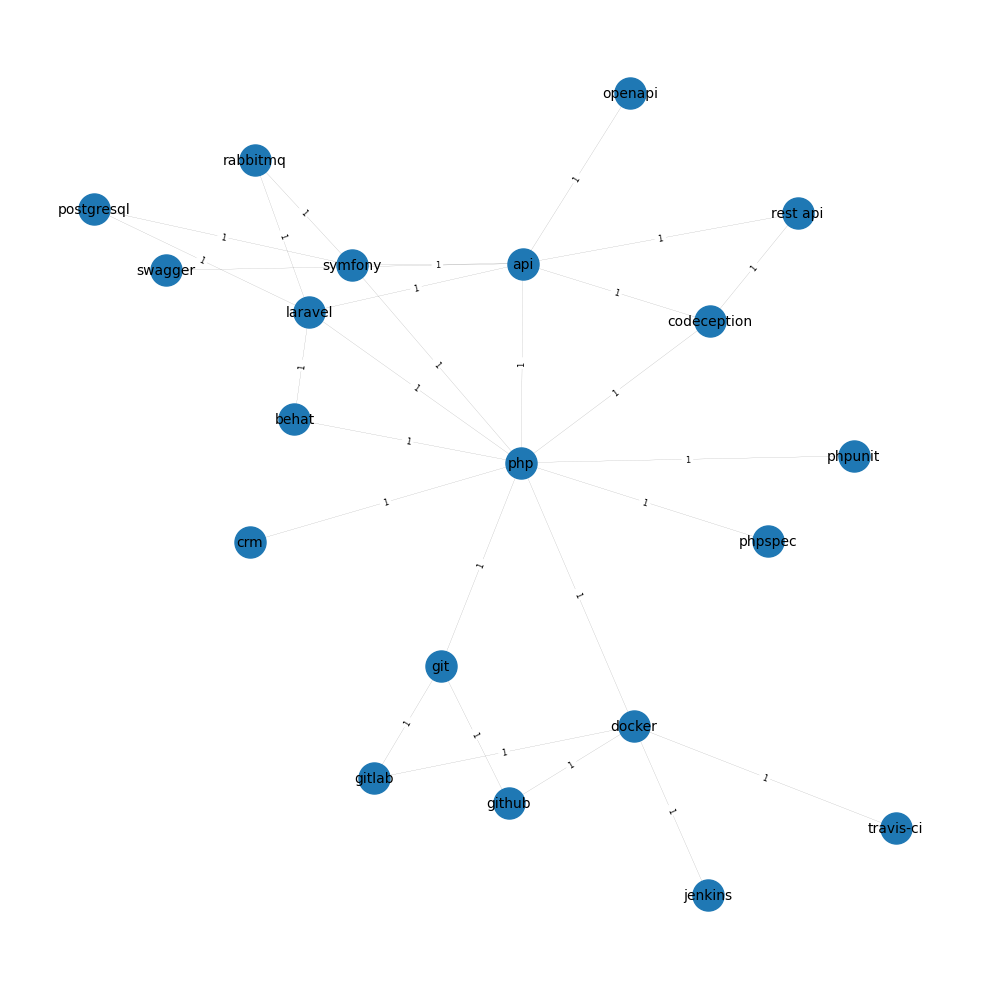

In [8]:
from graph.visualizer import visualize

# Изобразим граф навыков
visualize(graph, True)